# A Hybrid Generative-Discriminative Deep Model

Code to go along with [this blog post](http://www.openias.org/hybrid-generative-discriminative).

In [1]:
from __future__ import division

import numpy as np
import theano as th
#th.config.optimizer='fast_compile'
import theano.tensor as T
import theano.tensor.shared_randomstreams as tsr

np.random.seed(735)

epsilon = 1e-8

n_x = 2
n_h = 50
n_z = 2
n_c = 50
n_y = 2

beta = 0.25

figsize=(12, 10)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 35.0% of memory, cuDNN 5105)


# Generate a Toy Dataset

In [2]:
from moons import make_moons

x_toy, t_toy = make_moons(1000)

def onehot(t):
    y = np.zeros(shape=(t.shape[0], n_y), dtype=th.config.floatX)
    
    for d in range(n_y):
        y[t[:, 0] == d, d] = 1
    
    return y

y_toy = onehot(t_toy)

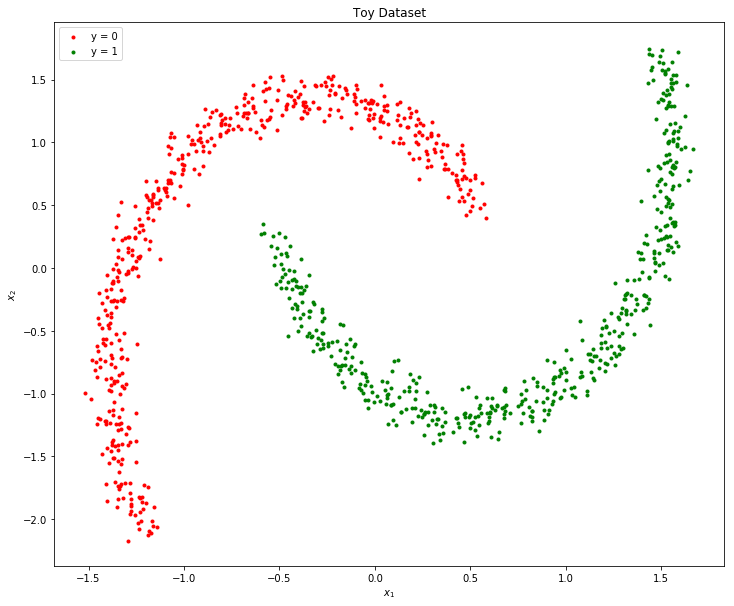

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=figsize)
plt.scatter(x_toy[y_toy.argmax(axis=1) == 0, 0], x_toy[y_toy.argmax(axis=1) == 0, 1],
            marker='.', label='y = 0', color='r')
plt.scatter(x_toy[y_toy.argmax(axis=1) == 1, 0], x_toy[y_toy.argmax(axis=1) == 1, 1],
            marker='.', label='y = 1', color='g')
plt.legend()
plt.title('Toy Dataset')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
    
plt.show()

# Construct the Model

## Utilities and Constants

In [4]:
all_params = []

def add_param(p):
    all_params.append(p)
    return p

def weights(name, n1, n2):
    return add_param(th.shared(np.random.normal(0, 0.05, size=(n1, n2)).astype(th.config.floatX), name=name))

def biases(name, n):
    return add_param(th.shared(np.zeros(shape=(n)).astype(th.config.floatX), name=name))

def nonlinearity(x):
    return T.nnet.relu(x, alpha=0)

## Input

In [5]:
x = T.matrix('x')
y = T.matrix('y')

## Encoder $q(z|x)$

In [6]:
# Encoder layer 1:

enc_l1_w = weights('enc_l1_w', n_x, n_h)
enc_l1_b = biases('enc_l1_b', n_h)

# Encoder layer 2:

enc_l2_w = weights('enc_l2_w', n_h, n_h)
enc_l2_b = biases('enc_l2_b', n_h)

# Encoder output layer:

z_mu_w = weights('z_mu_w', n_h, n_z)
z_mu_b = biases('z_mu_b', n_z)

z_ls_w = weights('z_ls_w', n_h, n_z)
z_ls_b = biases('z_ls_b', n_z)

def q_z_given_x(x):
    enc_l1 = nonlinearity(T.dot(x, enc_l1_w) + enc_l1_b)
    
    enc_l2 = nonlinearity(T.dot(enc_l1, enc_l2_w) + enc_l2_b)
    
    # NOTE: No nonlinearity() on z_mu(!) or we can't learn all means means.
    z_mu = T.dot(enc_l2, z_mu_w) + z_mu_b

    # NOTE: No nonlinearity() on z_ls(!) or we can't learn all standard deviations.
    z_ls = T.dot(enc_l2, z_ls_w) + z_ls_b
    
    return z_mu, z_ls

## Latent space

In [7]:
from theano.sandbox.rng_mrg import MRG_RandomStreams

srng = MRG_RandomStreams(733)

def sample(mu, ls):
    
    eps = srng.normal(size=mu.shape, dtype=th.config.floatX)

    return mu + T.exp(ls) * eps

## Decoder $q(x|z)$

In [8]:
# Decoder layer 1:

dec_l1_w = weights('dec_l1_w', n_z, n_h)
dec_l1_b = biases('dec_l1_b', n_h)

# Decoder hidden layer 2:

dec_l2_w = weights('dec_l2_w', n_h, n_h)
dec_l2_b = biases('dec_l2_b', n_h)

# Decoder output layer:

x_mu_w = weights('x_mu_w', n_h, n_x)
x_mu_b = biases('x_mu_b', n_x)

x_ls_w = weights('x_ls_w', n_h, n_x)
x_ls_b = biases('x_ls_b', n_x)

def q_x_given_z(z):
    
    dec_l1 = nonlinearity(T.dot(z, dec_l1_w) + dec_l1_b)

    dec_l2 = nonlinearity(T.dot(dec_l1, dec_l2_w) + dec_l2_b)

    # NOTE: No nonlinearity() on x_mu(!) or we can't learn all means.
    x_mu = T.dot(dec_l2, x_mu_w) + x_mu_b

    # NOTE: No nonlinearity() on x_ls(!) or we can't learn all standard deviations.
    x_ls = T.dot(dec_l2, x_ls_w) + x_ls_b
    
    return x_mu, x_ls

## Label decoder $q(y|z)$

In [9]:
# Classifier layer 1:

clr_l1_w = weights('clr_l1_w', n_z, n_c)
clr_l1_b = biases('clr_l1_b', n_c)

# Classifier hidden layer 2:

clr_l2_w = weights('clr_l2_w', n_c, n_c)
clr_l2_b = biases('clr_l2_b', n_c)

# Classifier output layer:

clr_lo_w = weights('clr_lo_w', n_c, n_y)
clr_lo_b = biases('clr_lo_b', n_y)

def q_y_given_z(z):
    
    clr_l1 = T.tanh(T.dot(z, clr_l1_w) + clr_l1_b)

    clr_l2 = T.tanh(T.dot(clr_l1, clr_l2_w) + clr_l2_b)

    return T.nnet.softmax(T.dot(clr_l2, clr_lo_w) + clr_lo_b)


## Connecting the Graph

In [10]:
(z_mu, z_ls) = q_z_given_x(x)

### Discriminative portion

In [11]:
q_y_given_x = q_y_given_z(z_mu)

### Generative portion

In [12]:
def __logsumexp(v, axis=0):
    v_max = T.max(v, axis=axis)
    return T.log(T.sum(T.exp(v - v_max), axis=axis)) + v_max

def __normal_log_pdf(x, mu, ls):
    return -0.5 * np.log(2*np.pi) - ls - (x - mu)**2 / (2 * T.exp(2 * ls) + epsilon)

K = 25

log_p_xy = []
for i in range(K):
    z = sample(z_mu, z_ls)
    
    log_p_z = T.sum(__normal_log_pdf(z, 0, np.log(1)), axis=1)
    log_p_z_given_x = T.sum(__normal_log_pdf(z, z_mu, z_ls), axis=1)
    
    (x_mu, x_ls) = q_x_given_z(z)
    log_p_x_given_z = T.sum(__normal_log_pdf(x, x_mu, x_ls), axis=1)
    
    log_p_y = - T.nnet.categorical_crossentropy(beta * q_y_given_x + (1 - beta) * q_y_given_z(z), y)
    
    log_p_xy.append(log_p_z - log_p_z_given_x + log_p_x_given_z + log_p_y)

elbo = T.mean(__logsumexp(T.stack(log_p_xy)))

## Inference

In [13]:
# Inference function that returns both (the logarithm of) an importance weight and a categorical distribution:
infer = th.function([x], [log_p_z - log_p_z_given_x + log_p_x_given_z,
                          beta * q_y_given_x + (1 - beta) * q_y_given_z(z)])

## Optimization

In [14]:
from lasagne.updates import rmsprop

print 'params:', all_params

updates = rmsprop(-elbo, all_params, learning_rate=0.0005)

train = th.function([x, y], elbo, updates=updates)

epochs = 20000

for epoch in range(epochs):
    
    epoch_elbo = train(x_toy, y_toy)

    if np.isnan(epoch_elbo):
        raise ValueError('Hit dreaded NaN after %d epochs' % (epoch))

    if epoch % int(epochs / 10) == 0:
        print "Epoch %04d/%d: ELBO = %5f" % (epoch, epochs, epoch_elbo)

params: [enc_l1_w, enc_l1_b, enc_l2_w, enc_l2_b, z_mu_w, z_mu_b, z_ls_w, z_ls_b, dec_l1_w, dec_l1_b, dec_l2_w, dec_l2_b, x_mu_w, x_mu_b, x_ls_w, x_ls_b, clr_l1_w, clr_l1_b, clr_l2_w, clr_l2_b, clr_lo_w, clr_lo_b]
Epoch 0000/20000: ELBO = -0.312121
Epoch 2000/20000: ELBO = 1.475571
Epoch 4000/20000: ELBO = 1.856348
Epoch 6000/20000: ELBO = 1.952537
Epoch 8000/20000: ELBO = 1.984166
Epoch 10000/20000: ELBO = 2.017377
Epoch 12000/20000: ELBO = 2.038005
Epoch 14000/20000: ELBO = 2.021170
Epoch 16000/20000: ELBO = 2.097653
Epoch 18000/20000: ELBO = 2.083486


# Visualization

In [15]:
def classify(x, samples):
    
    log_pi = []
    p_y = []

    for sample in range(samples):
        (log_w, p_y_given_x) = infer(x)

        log_pi.append(log_w)
        p_y.append(p_y_given_x)

    log_pi = np.stack(log_pi)
    p_y = np.stack(p_y)

    log_pi = np.nan_to_num(log_pi - log_pi.max(axis=0))

    y_hat = (np.exp(log_pi[:, :, np.newaxis]) * p_y).mean(axis=0)
    
    y_hat /= y_hat.sum(axis=1, keepdims=True)

    return y_hat.astype(th.config.floatX)

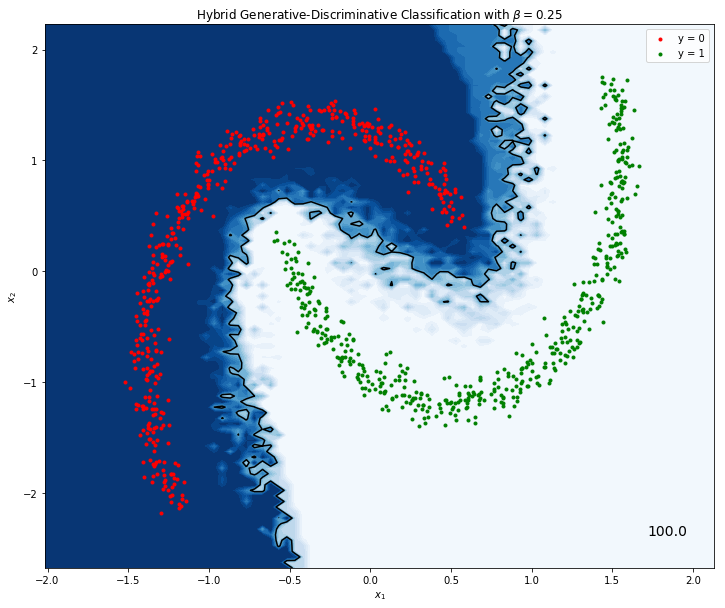

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.misc import logsumexp

plt.figure(figsize=figsize)

x1_min, x1_max = x_toy[:, 0].min() - .5, x_toy[:, 0].max() + .5
x2_min, x2_max = x_toy[:, 1].min() - .5, x_toy[:, 1].max() + .5

h = 0.05
    
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                       np.arange(x2_min, x2_max, h))

xx = np.c_[xx1.ravel(), xx2.ravel()].astype(th.config.floatX)

yy = classify(xx, 100)

plt.contourf(xx1, xx2, yy[:, 0].reshape(xx1.shape), levels=np.arange(21)/20.0, cmap='Blues')
plt.contour(xx1, xx2, yy[:, 0].reshape(xx1.shape), levels=[.5], colors=['k'])
plt.scatter(x_toy[y_toy.argmax(axis=1) == 0, 0], x_toy[y_toy.argmax(axis=1) == 0, 1],
            marker='.', label='y = 0', color='r')
plt.scatter(x_toy[y_toy.argmax(axis=1) == 1, 0], x_toy[y_toy.argmax(axis=1) == 1, 1],
            marker='.', label='y = 1', color='g')
plt.legend()
plt.title('Hybrid Generative-Discriminative Classification with $ \\beta = {} $'.format(beta))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

percent_correct = 100.0 * (classify(x_toy, 100).argmax(axis=1) == y_toy.argmax(axis=1)).mean()
plt.text(x1_max - 0.2, x2_min + 0.3,
         ('%.1f' % percent_correct).lstrip('0'),
         size=14, horizontalalignment='right')

plt.show()